!pip uninstall -y scikit-learn
!pip uninstall -y pandas

#!pip install scikit-learn==0.21.1
#!pip install pandas==0.24.2
#!pip3 install pandas_ml 
#!pip3 install pytorch_metric_learning 
!pip3 install faiss-cpu faiss-gpu

In [1]:
import os, sys
sys.path.append('pytorch_sol2/')
sys.path

['/floyd/home',
 '/usr/local/lib/python37.zip',
 '/usr/local/lib/python3.7',
 '/usr/local/lib/python3.7/lib-dynload',
 '',
 '/usr/local/lib/python3.7/site-packages',
 '/usr/local/lib/python3.7/site-packages/xgboost-1.0.2-py3.7.egg',
 '/usr/local/lib/python3.7/site-packages/IPython/extensions',
 '/root/.ipython',
 'pytorch_sol2/']

import torch
torch.__version__

In [2]:
import pandas as pd
import numpy as np
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from skimage import io, transform
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import torch.nn.functional as F

from config import *
from GalaxiesDataset import *
from rsa_loader import *
from efigi_loader import *
from pytorchtools import EarlyStopping
from myEfigiDML import *

import pickle
from label_smoothing import LabelSmoothingCrossEntropy
import warnings
warnings.filterwarnings('ignore')

from pytorch_metric_learning import losses, miners, distances, reducers, testers, regularizers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [3]:
transf = transforms.Compose([transforms.Resize((105, 105)),
                             transforms.RandomHorizontalFlip(p=0.5),
                             transforms.RandomRotation(degrees=(0,360)),
                             transforms.RandomVerticalFlip(p=0.5),
                             transforms.ToTensor(),
                             transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                  std=[0.229, 0.224, 0.225])])

transformations = transforms.Compose([transforms.Resize((105, 105)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
train_ds = GalaxiesDataset_efigi(EFIGI_DIR, EFIGI_CSV, transform=transformations)

In [5]:
cl = []
for row in range(train_ds.classes_frame.shape[0]):
    cl.append(np.argmax(train_ds.classes_frame.loc[:,train_ds.classes_frame.columns[3:]].loc[row]))

temp = pd.DataFrame(cl,columns=['cat'])
temp['cat'] = temp['cat'].astype('category')
temp['cat'] = temp['cat'].cat.codes


In [6]:
y = torch.from_numpy(temp.values)
train_idx, valid_idx= train_test_split(
np.arange(len(y)),
test_size=0.4,
shuffle=True,
    random_state=42,
stratify=y)

valid_idx, test_idx= train_test_split(
np.arange(len(y[valid_idx])),
test_size=0.5,
shuffle=True,
    random_state=42,
stratify=y[valid_idx])

In [7]:
size = len(train_ds)
indices = list(range(size))
split = int(np.floor(VALIDATION_SPLIT * size))
if SHUFFLE_DS:
    np.random.seed(RANDOM_SEED)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

test_split = int(np.floor(VALIDATION_SPLIT * len(train_indices)))
if SHUFFLE_DS:
    np.random.seed(RANDOM_SEED)
    np.random.shuffle(indices)
train_indices, test_indices = train_indices[test_split:], train_indices[:test_split]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler   = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=8,
                                                 sampler=train_sampler)
val_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=8,
                                                 sampler=val_sampler)
unseen_dl = DataLoader(train_ds,batch_size=BATCH_SIZE, num_workers=8,
                                                 sampler=test_sampler)
print("Total: {} Train_dl: {} Validation_dl: {} Unseen_dl: {}".format(size, len(train_dl),                                                                    
                                                              len(val_dl), len(unseen_dl)))

Total: 3122 Train_dl: 6 Validation_dl: 2 Unseen_dl: 2


In [8]:
device = torch.device(DEVICE)

In [9]:
#Change to 'val' if only want to evaluate
train_or_val = 'train'

In [10]:
mining_function = 'pair' #'triplet' 'pair'
loss = 'pnca' #'triplet' 'contrastive' 'panc' 'pnca' 'normsoftmax'

In [11]:
if train_or_val == 'train':
    model = torch.load('./models/efigi_label_smoothin_128')    
    del model.fc[6]
    del model.fc[5]
    del model.fc[4]
if train_or_val == 'val':
    pth = './models/efigi{}_{}_128'.format(mining_function, loss)
    model = torch.load(pth)

In [12]:
optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=0.05, nesterov=True, weight_decay=0.0005)
criterion = LabelSmoothingCrossEntropy(reduction='mean')
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=3,threshold=0.0001,factor=0.1, verbose=True)

Training beginning
Epoch: 1 Train Loss: 12.203078428904215
Epoch: 1 Val Loss: 12.236479759216309
Epoch: 2 Train Loss: 12.209271430969238
Epoch: 2 Val Loss: 12.265039920806885
Epoch: 3 Train Loss: 12.200816790262857
Epoch: 3 Val Loss: 12.237751483917236
Epoch: 4 Train Loss: 12.201085408528646
Epoch: 4 Val Loss: 12.185166835784912
Epoch: 5 Train Loss: 12.19572385152181
Epoch: 5 Val Loss: 12.203165531158447
Epoch: 6 Train Loss: 12.206889629364014
Epoch: 6 Val Loss: 12.266556739807129
Epoch: 7 Train Loss: 12.21723477045695
Epoch: 7 Val Loss: 12.253966331481934
Epoch: 8 Train Loss: 12.20636256535848
Epoch     8: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 8 Val Loss: 12.233958721160889
Epoch: 9 Train Loss: 12.194005012512207
Epoch: 9 Val Loss: 12.256393432617188
Epoch: 10 Train Loss: 12.194367090861002
Epoch: 10 Val Loss: 12.18955659866333
Epoch: 11 Train Loss: 12.18786096572876
Epoch: 11 Val Loss: 12.248773574829102
Epoch: 12 Train Loss: 12.186169942220053
Epoch    12: reducing

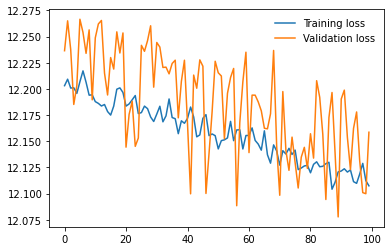

Training complete


In [13]:
efigiDML = myEfigiDML(train_dl, val_dl, unseen_dl, model, optimizer, scheduler, criterion,mining_function, 
                      loss, device=device,BATCH_SIZE=BATCH_SIZE)
if train_or_val == 'train':
    efigiDML.train(n_epochs=100)

In [14]:
test_ds = GalaxiesDataset_rsa(TEST_DIR, TEST_CSV, transform=transformations)
size = len(test_ds)
indices = list(range(size))
test_sampler = SubsetRandomSampler(indices)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=4,
                                                 sampler=test_sampler)
print("Total: {} Test_dl: {}".format(size, len(test_dl)))

Total: 1249 Test_dl: 4


In [15]:
res = efigiDML.RSAtest(test_dl)

Evaluation on RSA test set beginning:
Accuracy on RSA test set: 22.98
MAP@R on RSA test set: 0.2948
